# Кластеризация
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[ML][MS][HW02] <ФИО>`, где вместо `<ФИО>` указаны фамилия и имя__

В этом домашнем задании предлагается реализовать три различных метода кластеризации, понять, в каких случаях стоит применять те или иные методы, а так же применить один из алгоритмов к задаче уменьшения цветности изображения.

In [1]:
from sklearn.neighbors import KDTree
from sklearn.datasets import make_blobs, make_moons, make_swiss_roll
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import cv2
from collections import deque
from typing import NoReturn

In [2]:
def visualize_clasters(X, labels):
    unique_labels = np.unique(labels)
    unique_colors = np.random.random((len(unique_labels), 3))
    colors = [unique_colors[l] for l in labels]
    plt.figure(figsize=(9, 9))
    plt.scatter(X[:, 0], X[:, 1], c=colors)
    plt.show()

def clusters_statistics(flatten_image, cluster_colors, cluster_labels):
    fig, axes = plt.subplots(3, 2, figsize=(12, 16))
    for remove_color in range(3):
        axes_pair = axes[remove_color]
        first_color = 0 if remove_color != 0 else 2
        second_color = 1 if remove_color != 1 else 2
        axes_pair[0].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=flatten_image, marker='.')
        axes_pair[1].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=[cluster_colors[c] for c in cluster_labels], marker='.')
        for a in axes_pair:
            a.set_xlim(0, 1)
            a.set_ylim(0, 1)
    plt.show()

Генерируем два синтетических набора данных для кластеризации. Далее будем тестировать наши алгоритмы на них.

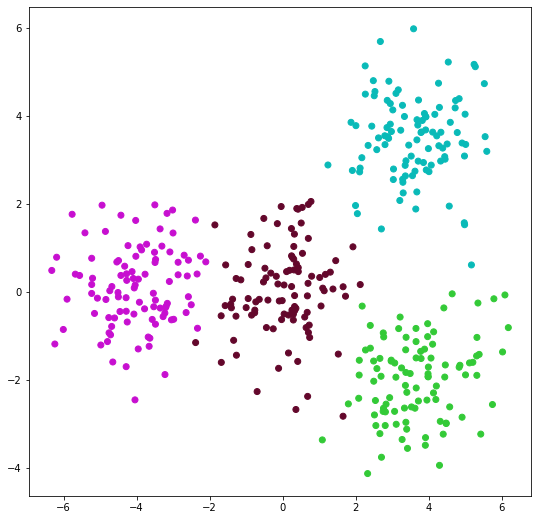

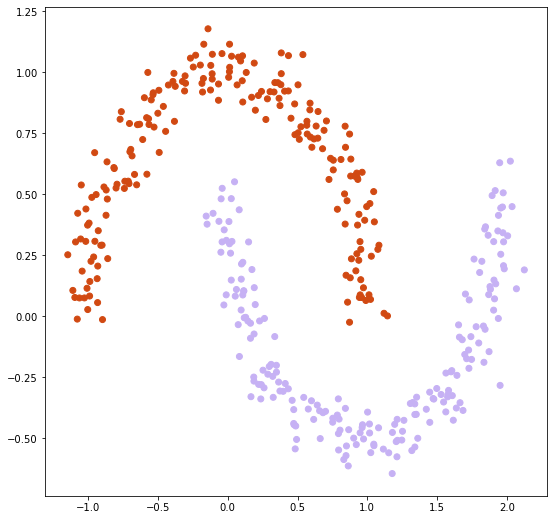

In [3]:
X_1, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])
visualize_clasters(X_1, true_labels)
X_2, true_labels = make_moons(400, noise=0.075)
visualize_clasters(X_2, true_labels)

### Задание 1 (3 балла)
Первый метод, который предлагается реализовать - метод K средних.

#### Описание методов
`fit(X, y=None)` ищет и запоминает в `self.centroids` центроиды кластеров для набора данных.
`predict(X)` для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент.

#### Инициализация кластеров
Есть несколько вариантов инициализации кластеров. Нужно реализовать их все:
1. `random` - центроиды кластеров являются случайными точками
2. `sample` - центроиды кластеров выбираются случайно из набора данных
3. `k-means++` - центроиды кластеров инициализируются при помощи метода K-means++

__Не забудте реинициализировать пустые кластеры!__

In [4]:
class KMeans:
    def __init__(self, n_clusters: int, init: str = "random",
                 max_iter: int = 300):
        """

        Parameters
        ----------
        n_clusters : int
            Число итоговых кластеров при кластеризации.
        init : str
            Способ инициализации кластеров. Один из трех вариантов:
            1. random --- центроиды кластеров являются случайными точками,
            2. sample --- центроиды кластеров выбираются случайно из  X,
            3. k-means++ --- центроиды кластеров инициализируются
                при помощи метода K-means++.
        max_iter : int
            Максимальное число итераций для kmeans.

        """
        self.n_clusters = n_clusters
        self.init = init
        self.max_iter = max_iter

    def _calc_dist(self, X, points):
        return np.array([np.sum((X - y) ** 2, axis=1) ** (1 / 2) for y in points])

    def _init_centroids(self, n, X) -> np.ndarray:
        if self.init == 'sample':
            ind = np.random.choice(X.shape[0], size=n)
            return X[ind]
        if self.init == 'random':
            mins = np.amin(X, axis=0)
            maxs = np.amax(X, axis=0)
            res = np.random.uniform(mins, maxs, (n, X.shape[1]))
            return res
        if self.init == 'k-means++':
            ind = np.random.randint(X.shape[0], size=n)
            centroids = np.array(X[ind])
            for i in range(1, n):
                dists = self._calc_dist(X, centroids)
                dists = np.amin(dists, axis=0) ** 2
                high = np.sum(dists)
                prob = np.random.uniform(high, size=1)

                ind = 0
                sum = 0
                for j in range(X.shape[0]):
                    sum += dists[i]
                    if prob <= sum:
                        ind = j
                        break
                centroids = np.vstack((centroids, X[ind]))
            return centroids

    def fit(self, X: np.array, y=None) -> NoReturn:
        """
        Ищет и запоминает в self.centroids центроиды кластеров для X.

        Parameters
        ----------
        X : np.array
            Набор данных, который необходимо кластеризовать.
        y : Ignored
            Не используемый параметр, аналогично sklearn
            (в sklearn считается, что все функции fit обязаны принимать
            параметры X и y, даже если y не используется).

        """
        centroids = self._init_centroids(self.n_clusters, X)
        y = np.zeros(X.shape[0])
        for _ in range(self.max_iter):
            y = np.argmin(self._calc_dist(X, centroids), axis=0)
            centroids = np.array([np.mean(X[y == cluster], axis=0) for cluster in range(self.n_clusters)])
        self.centroids = centroids

    def predict(self, X: np.array) -> np.array:
        """
        Для каждого элемента из X возвращает номер кластера,
        к которому относится данный элемент.

        Parameters
        ----------
        X : np.array
            Набор данных, для элементов которого находятся ближайшие кластера.

        Return
        ------
        labels : np.array
            Вектор индексов ближайших кластеров
            (по одному индексу для каждого элемента из X).

        """
        y = np.argmin(self._calc_dist(X, self.centroids), axis=0)
        return y


Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

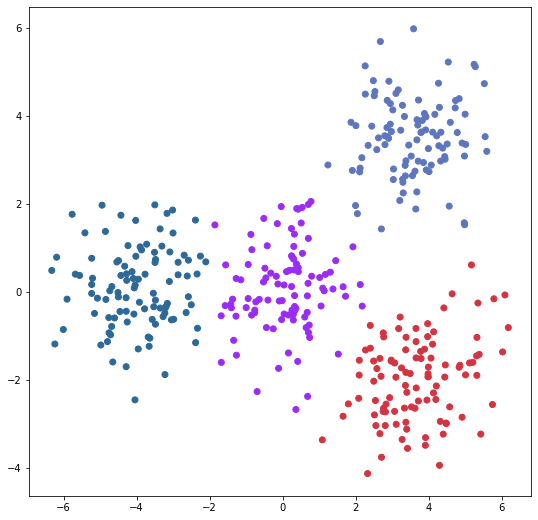

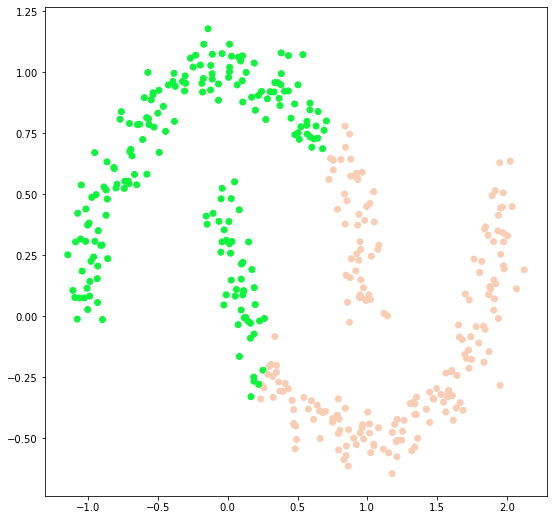

In [5]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X_1)
labels = kmeans.predict(X_1)
visualize_clasters(X_1, labels)

kmeans = KMeans(n_clusters=2, init='k-means++')
kmeans.fit(X_2)
labels = kmeans.predict(X_2)
visualize_clasters(X_2, labels)

### Задание 2 (2 балла)
В отличии от K-means, DBScan не позволяет задать количество кластеров, на которое будут разбиты данные. Руководствуясь геометрической интерпретацией, он позволяет выделять кластеры более сложной формы.

#### Описание методов
`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

#### Возможные метрики
* `euclidean`
* `manhattan`
* `chebyshev`

__Для быстрого поиска соседей используйте `sklearn.neighbors.KDTree`__

In [6]:
class DBScan:
    def __init__(self, eps: float = 0.5, min_samples: int = 5,
                 leaf_size: int = 40, metric: str = "euclidean"):
        """

        Parameters
        ----------
        eps : float, min_samples : int
            Параметры для определения core samples.
            Core samples --- элементы, у которых в eps-окрестности есть
            хотя бы min_samples других точек.
        metric : str
            Метрика, используемая для вычисления расстояния между двумя точками.
            Один из трех вариантов:
            1. euclidean
            2. manhattan
            3. chebyshev
        leaf_size : int
            Минимальный размер листа для KDTree.

        """
        self.eps = eps
        self.min_samples = min_samples
        self.leaf_size = leaf_size
        metrics = {
            'euclidean': lambda x, y: np.linalg.norm(x - y),
            'manhattan': lambda x, y: np.sum(np.abs(x - y)),
            'chebyshev': lambda x, y: np.max(np.abs(x - y))
        }
        self.dist = metrics[metric]
        self.metric = metric
        self.neighbours = {}

    def fit_predict(self, X: np.array, y=None) -> np.array:
        """
        Кластеризует элементы из X,
        для каждого возвращает индекс соотв. кластера.
        Parameters
        ----------
        X : np.array
            Набор данных, который необходимо кластеризовать.
        y : Ignored
            Не используемый параметр, аналогично sklearn
            (в sklearn считается, что все функции fit_predict обязаны принимать
            параметры X и y, даже если y не используется).
        Return
        ------
        labels : np.array
            Вектор индексов кластеров
            (Для каждой точки из X индекс соотв. кластера).

        """
        kd = KDTree(X, leaf_size=self.leaf_size, metric=self.metric)
        y = np.ones(X.shape[0], dtype=int) * -1
        g = kd.query_radius(X, self.eps,
                            return_distance=False,
                            count_only=False)

        def dfs(x):
            nb_inds = g[x]
            for v in nb_inds:
                v_nb = g[v]
                if len(v_nb) - 1 <= self.min_samples:
                    y[v] = y[x]
                    continue
                if y[v] == -1:
                    y[v] = y[x]
                    dfs(v)

        cl = 0
        for i in range(len(y)):
            if len(g[i]) > self.min_samples and y[i] == -1:
                y[i] = cl
                cl += 1
                dfs(i)
        return y

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

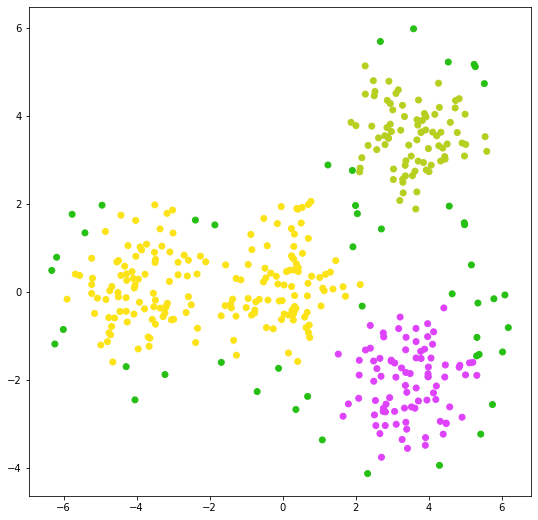

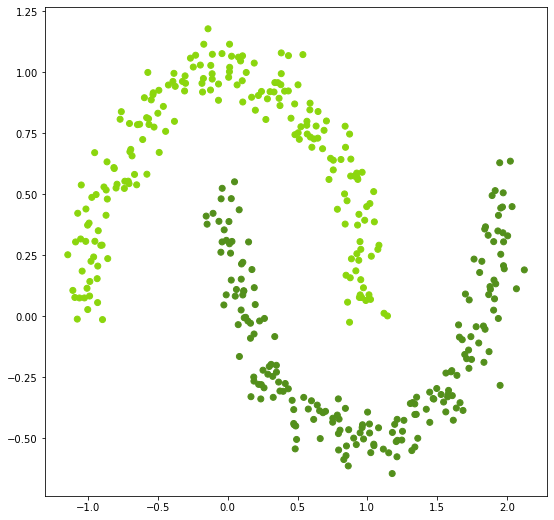

In [7]:
dbscan = DBScan(eps=1, min_samples=11, metric='manhattan')
labels = dbscan.fit_predict(X_1)
visualize_clasters(X_1, labels)

dbscan = DBScan(eps=0.2)
labels = dbscan.fit_predict(X_2)
visualize_clasters(X_2, labels)

### Задание 3 (3 балла)
Идея AgglomerativeClustering заключается в том, чтобы итеративно объединять кластеры с наименьшим расстоянием между ними. Данный метод обладает высокой вычислительной сложностью, поэтому применим только для относительно небольших наборов данных.

#### Описание методов
`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

#### Linkage-функции
__Linkage__ - это способ, которым будет рассчитываться расстояние между кластерами. Предлагается реализовать три варианта такой функции:
1. `average` - расстояние рассчитывается как среднее расстояние между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `single` - расстояние рассчитывается как минимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `complete` - расстояние рассчитывается как максимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.

In [8]:
class AgglomertiveClustering:
    def __init__(self, n_clusters: int = 16, linkage: str = "average"):
        """

        Parameters
        ----------
        n_clusters : int
            Количество кластеров, которые необходимо найти (то есть, кластеры
            итеративно объединяются, пока их не станет n_clusters)
        linkage : str
            Способ для расчета расстояния между кластерами. Один из 3 вариантов:
            1. average --- среднее расстояние между всеми парами точек,
               где одна принадлежит первому кластеру, а другая - второму.
            2. single --- минимальное из расстояний между всеми парами точек,
               где одна принадлежит первому кластеру, а другая - второму.
            3. complete --- максимальное из расстояний между всеми парами точек,
               где одна принадлежит первому кластеру, а другая - второму.
        """
        self.linkage = linkage
        self.n_clusters = n_clusters
        dd = {
            'average': lambda a, b: (a + b) / 2,
            'single': min,
            'complete': max
        }
        self.metric = dd[linkage]

    def _calc_dist(self, cl1, cl2):
        return np.array([np.sum((cl1 - y) ** 2, axis=1) ** (1 / 2) for y in cl2])

    def fit_predict(self, X: np.array, y=None) -> np.array:
        """
        Кластеризует элементы из X,
        для каждого возвращает индекс соотв. кластера.
        Parameters
        ----------
        X : np.array
            Набор данных, который необходимо кластеризовать.
        y : Ignored
            Не используемый параметр, аналогично sklearn
            (в sklearn считается, что все функции fit_predict обязаны принимать
            параметры X и y, даже если y не используется).
        Return
        ------
        labels : np.array
            Вектор индексов кластеров
            (Для каждой точки из X индекс соотв. кластера).

        """
        y = np.arange(X.shape[0])
        i = len(y)
        metric_matrix = self._calc_dist(X, X)

        for i in range(len(y)):
            metric_matrix[i, i] = 1e9

        clusters = np.unique(y)
        while len(clusters) > self.n_clusters:
            cl1, cl2 = np.unravel_index(np.argmin(metric_matrix, axis=None), metric_matrix.shape)
            for cl in clusters:
                if cl == cl1:
                    continue
                metric_matrix[cl1, cl] = self.metric(metric_matrix[cl1, cl], metric_matrix[cl2, cl])
                metric_matrix[cl, cl1] = metric_matrix[cl1, cl]

            y[y == cl2] = cl1
            metric_matrix[cl2] = 1e9
            metric_matrix[:, cl2] = 1e9

            clusters = np.unique(y)
            i -= 1

        for i in range(len(clusters)):
            y[y == clusters[i]] = i

        return y

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

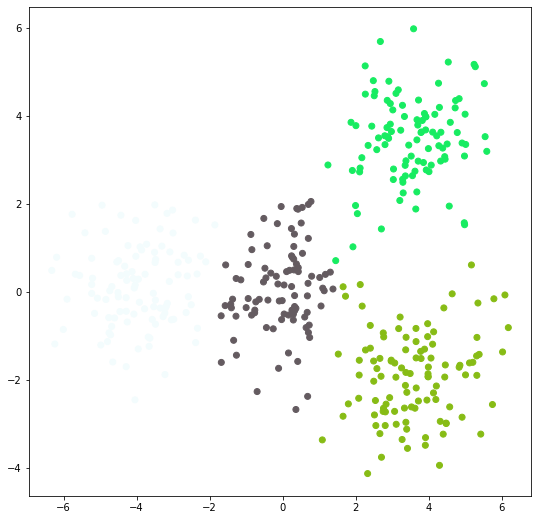

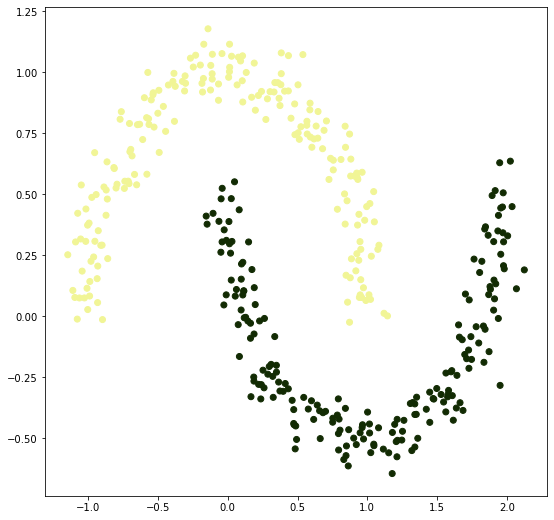

In [9]:
agg_clustering = AgglomertiveClustering(n_clusters=4, linkage='average')
labels = agg_clustering.fit_predict(X_1)
visualize_clasters(X_1, labels)

agg_clustering = AgglomertiveClustering(n_clusters=2, linkage='single')
labels = agg_clustering.fit_predict(X_2)
visualize_clasters(X_2, labels)

### Задание 4 (1 балл)
Реализуйте методы считывания и записи изображения при помощи библиотеки OpenCV. 

#### Описание методов
`read_image(path)` читает изображение и возвращает его в виде трехмерного numpy массива размера `(N, M, C)`, где `N` и `M` - размеры изображения, а `C` - количество цветов (3 для обычного изображения)
`save_image(image, path)` сохраняет изображение.

__Учтите, что `cv2.imread` считывает изображение в цветовой схеме BGR. После считывания необходимо перевести его в RGB и нормализовать__

In [10]:
def read_image(path: str) -> np.array:
    """
    Читает изображение.

    Parameters
    ----------
    path : str
        Путь к изображению.

    Return
    ------
    image : np.array
        Трехмерный массив размера (N, M, C),
        где N и M - размеры изображения,
        а C - количество цветов (3 для обычного изображения).
    """
    mat = cv2.imread(path)
    mat = cv2.cvtColor(mat, cv2.COLOR_BGR2RGB)
    return np.asarray(mat[:, :])

def show_image(image: np.array) -> NoReturn:
    """
    Выводит изображение

    Parameters
    ----------
    image : np.array
        Трехмерный массив - нормализованное изображение в цветовой схеме RGB.
    """
    plt.figure(figsize=np.array(image.shape[:-1]) / 50)
    plt.imshow(image)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    
def save_image(image: np.array, path: str) -> NoReturn:
    """
    Сохраняет изображение.

    Parameters
    ----------
    image : np.array
        Трехмерный массив - нормализованное изображение в цветовой схеме RGB.
    path : str
        Путь для сохранения.
    """
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    cv2.imwrite(path, image)

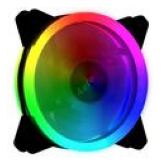

In [11]:
np_img = read_image("img5.jpg")
show_image(np_img)

### Задание 5 (1 балл)
Реализуйте функцию, которая будет кластеризовать цвета изображения одним из реализованных алгоритмов. Интерфейс этой функции можно менять. Функция должна возвращать новое изображение, в котором цвета заменены на цвета кластеров.

Затем примените ее к цветам изображения.

__Примечание: это задание проще всего выполнить при помощи KMeans__

In [12]:
def clusterize_image(image, n_clusters=10):
    km = KMeans(n_clusters=n_clusters, init='k-means++')
    img_flat = image.reshape(-1, image.shape[-1])
    km.fit(img_flat)
    clusters = km.predict(img_flat)

    recolored = img_flat
    cluster_colors = []
    for i in range(n_clusters):
        col = np.mean(img_flat[clusters == i], axis=0)
        recolored[clusters == i] = col
        cluster_colors.append(col)
    recolored = recolored.reshape(image.shape)
    clusters_statistics(image.reshape(-1, 3) / 255, np.array(cluster_colors) / 255, clusters)  # Very slow (:
    return recolored

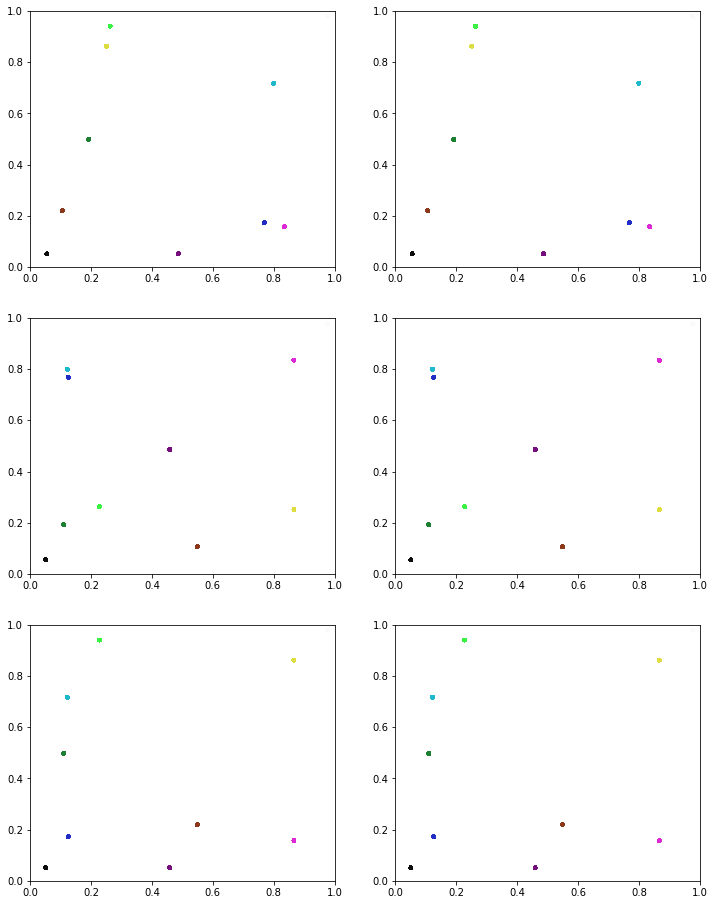

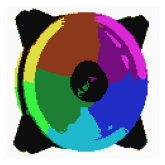

In [13]:
image = read_image("img5.jpg")
result = clusterize_image(image)
show_image(result)
save_image(result, "result.jpg")